In [1]:
# General
import os
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
from math import floor, ceil

# PSF - STAR direct
import webbpsf
import webbpsf.roman

# Gaussian - GALAXY direct
from astropy.modeling.functional_models import Gaussian2D as gauss

# pysynphot - work with spectra
import pysynphot as S

# Astropy - read files
from astropy.io import fits
from astropy.table import Table

# Grizli - sim
from grizli.model import GrismFLT

# Progress bar
from tqdm import tqdm
from IPython.display import clear_output

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/")

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
# Name all relevant files & load in catalog
direct_file = "ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
empty_seg = "empty_seg.fits"
empty_direct = "empty_direct.fits"

hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format="ascii")
hlss_tbl = hlss_tbl.group_by("MODIMAGE")
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True)


# While testing and imporving sim, I'm only using a small cutout
x_pos = 2124
y_pos = 1223
size = 500
cutout_condition = (abs(hlss_tbl["X_IMAGE"] - x_pos) < size) & (abs(hlss_tbl["Y_IMAGE"] - y_pos) < size)
cutout_tbl = hlss_tbl[np.where(cutout_condition)]

In [3]:
# Generate and Save an empty segmentation fits and direct fits
zero_data = np.zeros((4088,4088))

# Take header info from prepared direct image
file = fits.open(direct_file)
phdu = file[0]
hdr = file[1].header

# Structure empty direct fits
ihdu = fits.ImageHDU(data=zero_data, header=hdr, name="SCI")
errhdu = fits.ImageHDU(data=zero_data, header=hdr, name="ERR")
dqhdu = fits.ImageHDU(data=zero_data, header=hdr, name="DQ")
hdul = [phdu, ihdu, errhdu, dqhdu]

# Save both files
fits.HDUList(hdul).writeto(empty_direct, overwrite=True)
fits.writeto(empty_seg, data=zero_data, header=hdr, overwrite=True)

# I/O and cleaning
file.close()
del zero_data
del phdu
del hdr
del ihdu
del errhdu
del dqhdu
del hdul

In [4]:
# Maybe functional amplitdue functions?
f158_lam_center = 1.577 * 10**-6 # micrometer
telarea = 2.36**2 * constants.pi # meter ** 2

f_0 = 3.7059108273831045e-10 # this is just a number that seems to work; theoretically, this is comparable to an ABZeropoint

# Calculate number of counts as a function of magnitude
N = lambda mag: telarea * (f158_lam_center / (constants.h * constants.speed_of_light)) * f_0 * 10**(-0.4 * mag)

# Calculate 2D Gassian amplitude as a function of galaxy shape and magnitude
amplitude_func = lambda x_stddev, y_stddev, mag: N(mag) / (2 * constants.pi * x_stddev * y_stddev)

In [6]:
# Instantiate Grizli
pad = 100
roman_sim = GrismFLT(direct_file=empty_direct, seg_file=empty_seg, pad=pad)

# Instantiate empty segmentation map and direct image
# This will be filled with every iteration so you can see at the end what Grizli had to work with
# Useful for troubleshooting; can (and probably should) delete eventually to imporve runtime
full_seg = np.zeros((4088, 4088))
full_direct = np.zeros((4088, 4088))



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [7]:
# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

error_file = open("super_errors.txt", "a+")

for object in tqdm(cutout_tbl):

    # DIRECT SIMULATION --------------------------

    # Take object info
    id = object["NUMBER"]
    mag = object["MAG_F1500W"]
    x_0 = object["X_IMAGE"]
    y_0 = object["Y_IMAGE"]
    modimage = object["MODIMAGE"]

    # STAR
    if modimage:
        continue

    # GALAXY
    else:
        x_mean = y_0 # x and y are flipped in Gaussian2D
        y_mean = x_0 # x and y are flipped in Gaussian2D
        x_stddev = object["B_IMAGE"] # Semi-minor is x-axis per testing
        y_stddev = object["A_IMAGE"] # Semi-major is y-axis per testing
        theta = object["THETA_IMAGE"]

        amplitude = amplitude_func(x_stddev, y_stddev, mag)
        args = (amplitude, x_mean, y_mean, x_stddev, y_stddev, theta)

        dir_array = np.fromfunction(lambda i,j: gauss.evaluate(i, j, *args), shape=(4088,4088))

        roman_sim.direct.data["SCI"] = np.rot90(dir_array, k=3).astype("float32")
                                        
        full_direct += np.rot90(dir_array, k=3).astype("float32")

    # SEGMENTATION -------------------------------

    temp_seg = np.zeros((4088,4088), dtype="float32")

    # # STAR
    # if modimage:
    #     continue

    # # GALAXY
    # else:
    #     a = object["A_IMAGE"]
    #     b = object["B_IMAGE"]
    #     theta = object["THETA_IMAGE"]
    #     radius = 3

    #   # Create meshgrid cutout
    #     x_min = max(0, int(x_0 - radius + 1))
    #     x_max = min(4087, int(x_0 + radius + 1) + 1)
    #     y_min = max(0, int(y_0 - radius + 1))
    #     y_max = min(4087, int(y_0 + radius + 1) + 1)
    #     x_cutout = np.arange(x_min, x_max)
    #     y_cutout = np.arange(y_min, y_max)
    #     x_grid, y_grid = np.meshgrid(x_cutout, y_cutout)

    #     ellipse = lambda x,y: gen_ellipse(x, y, x_0, y_0, (theta, a, b))
    #     condition = ellipse(x_grid, y_grid) <= radius
    
    condition = (roman_sim.direct.data["SCI"] != 0)
    temp_seg[np.where(condition)] = id 

    if not np.any(temp_seg):
        error_file.write("ID {0} not in temp_seg \n".format(id))
        continue
    roman_sim.seg = temp_seg
    full_seg += temp_seg
    # GRISM SIMULATION ---------------------------

    # STAR
    if object["MODIMAGE"]:
        sed_path = "/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/ukg0v.fits"
        file = fits.open(sed_path)
        wave = np.linspace(10000,20000,2000)
        flux = file[0].data[1770:3770]
        file.close()
        z = 0

    # GALAXY
    else:
        sed_path = os.path.join(SED_dir, "SED:rest:gal.{0}.fits".format(object["SPECTEMP"]))
        spectrum = Table.read(sed_path, format="fits")
        wave = spectrum["wavelength"]
        flux = spectrum["flux"]
        z = object['Z']

    spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam").redshift(z)
    spec = spec.renorm(mag, "abmag", bp)
    spec.convert("flam")

    roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, 
                                   in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux], is_cgs=True)

100%|██████████| 681/681 [02:35<00:00,  4.39it/s]


In [8]:
print(f"min: {full_direct.min()}", f"max: {full_direct.max()}", f"median: {np.median(full_direct)}", sep='\n')

min: 0.0
max: 205.95549011238438
median: 3.36333567924636e-36


In [9]:
hlss_tbl[hlss_tbl["NUMBER"] == 30267]

NUMBER,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,MAG_F1500W,SPECTEMP,Z,MODIMAGE,MODIMAGE_1,MODIMAGE_2
int64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64
30267,2573.9223,831.3842,220.9088,117.9295,240.01,23.21,30267,1.635397,0,9.4423526,-0.7739819


In [10]:
full_seg

array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ..., 30267., 30267., 30267.],
       [    0.,     0.,     0., ..., 30267., 30267., 30267.],
       [    0.,     0.,     0., ..., 30267., 30267., 30267.]])

In [12]:
sim_min = roman_sim.model.min()
sim_max = roman_sim.model.max()
sim_median = np.median(roman_sim.model[723:1723, 1624:2624])

print(f"min: {sim_min}", f"max: {sim_max}", f"median: {sim_median}", sep='\n')

min: 0.0
max: 1.8604341745376587
median: 0.0


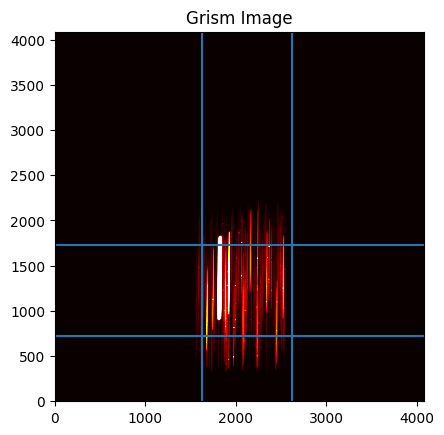

In [13]:
fig, ax = plt.subplots()

upright_img = np.rot90(roman_sim.model[pad:-pad,pad:-pad])
ax.imshow(upright_img, origin='lower', vmin=0, vmax=0.11738539732765789, cmap='hot')
ax.set_title("Grism Image")

ax.axvline(1624)
ax.axvline(2624)
ax.axhline(723)
ax.axhline(1723)